In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import cv2

import plotly
from plotly.graph_objs import *

import time

# from ndreg import *
# import ndio.remote.neurodata as neurodata
import nibabel as nib

In [2]:
def plot_hist(im, title=''):
    hist,bins = np.histogram(im.flatten(),256,[0,256])

    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()

    plt.plot(cdf_normalized, color = 'b')
    plt.hist(im.flatten(),256,[0,256], color = 'r')
    plt.title(title)
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.show()

In [3]:
def img_copy(img):
    """
    Returns a copy of the input image
    """
    return sitk.Image(img)

In [4]:
def thresh(im, val):
    """Thresholding the image s.t. any pixel with intensity less than val is set to 0, and
    and pixel with intensity above is set to 255. 
    """
    im_t = np.copy(im)

    for x in range(im.shape[0]):
        for y in range(im.shape[1]):
            for z in range(im.shape[2]):
                if im[x, y, z] < val:
                    im_t[x, y, z] = 0
                else:
                    im_t[x, y, z] = 255
                    
    return im_t

In [5]:
def thresh_cdf(im, percentile):
    im_t = np.copy(im)
    
    (values, bins) = np.histogram(im_t, bins=1000)
    cumValues = np.cumsum(values).astype(float)
    cumValues = (cumValues - cumValues.min()) / cumValues.ptp()
    
    maxIndex = np.argmax(cumValues>percentile)-1
    threshold = bins[maxIndex]
    print(threshold)

    result = thresh(im_t, threshold)
                    
    return result

## Real Data

In [6]:
%matplotlib inline
from ndreg import *
import matplotlib
import ndio.remote.neurodata as neurodata
import numpy as np
import cv2
import nibabel as nib

In [7]:
inToken = "Fear199"

inImg = imgDownload(inToken, resolution=5)
imgShow(inImg, vmax=500)

inImg_backup = img_copy(inImg)

refToken = "ara_ccf2"
refImg = imgDownload(refToken)
# imgShow(refImg, vmax=500)

KeyboardInterrupt: 

In [ ]:
inImg = img_copy(inImg_backup)
imgShow(inImg, vmax=500)

In [ ]:
refAnnoImg = imgDownload(refToken, channel="annotation")
imgShow(refAnnoImg, vmax=1000)

In [ ]:
print(refImg.GetSpacing())
print(inImg.GetSpacing())

# Respacing according to the reference image
inImg = imgResample(inImg, spacing=refImg.GetSpacing())
imgShow(inImg, vmax=500)

# Reorienting
inImg = imgReorient(inImg, "LAI", "RSA")
imgShow(inImg, vmax=500)

# Thresholding
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

counts = np.bincount(values)
maximum = np.argmax(bins)
print(maximum)
# print(counts)

lowerThreshold = maximum
upperThreshold = sitk.GetArrayFromImage(inImg).max()+1

print(lowerThreshold)
print(upperThreshold)


# 3, 2, 1
inImg = sitk.Threshold(inImg,lowerThreshold,upperThreshold,lowerThreshold) - lowerThreshold
imgShow(inImg, vmax = 500)

(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

imgShow(inImg, vmax=500)

# # Saving image
# location = "img/" + 'Fear199' + "_thresh.nii"
# imgWrite(inImg, str(location))

In [ ]:
# Generating CLARITY mask
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=1000)
cumValues = np.cumsum(values).astype(float)
cumValues = (cumValues - cumValues.min()) / cumValues.ptp()

maxIndex = np.argmax(cumValues>0.95)-1
threshold = bins[maxIndex]
print(threshold)

inMask = sitk.BinaryThreshold(inImg, 0, threshold, 1, 0)
imgShow(inMask)

imgShow(imgMask(inImg,inMask))

## Affine transformation

In [ ]:
spacing=[0.25,0.25,0.25]
refImg_ds = imgResample(refImg, spacing=spacing)
imgShow(refImg_ds, vmax=500)

inImg_ds = imgResample(inImg, spacing=spacing)
imgShow(inImg_ds, vmax=500)


inMask_ds = imgResample(inMask, spacing=spacing, useNearest=True)
imgShow(inMask_ds)

In [ ]:
affine = imgAffineComposite(inImg_ds, refImg_ds, inMask=inMask_ds, iterations=100, useMI=True, verbose=True)

In [ ]:
inImg_affine = imgApplyAffine(inImg, affine, size=refImg.GetSize())
imgShow(inImg_affine, vmax=500)

inMask_affine = imgApplyAffine(inMask, affine, size=refImg.GetSize(), useNearest=True)
imgShow(inMask_affine)

# LDDMM


Step 0: alpha=0.05, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-1.78342e+10, 48.557, 0, -1.78342e+10 (97.3796%), 1.100000e-03
1.	-1.88336e+10, 146.785, 0, -1.88336e+10 (96.2858%), 1.210000e-03
2.	-2.00771e+10, 351.019, 0, -2.00771e+10 (94.9248%), 1.331000e-03
3.	-2.06717e+10, 603.903, 0, -2.06717e+10 (94.274%), 1.464100e-03
4.	-2.12029e+10, 898.325, 0, -2.12029e+10 (93.6926%), 1.610510e-03
5.	-2.15684e+10, 1054.78, 0, -2.15684e+10 (93.2926%), 8.857805e-04
6.	-2.24277e+10, 1202.72, 0, -2.24277e+10 (92.3521%), 9.743586e-04
7.	-2.271e+10, 1302.83, 0, -2.271e+10 (92.0431%), 5.358972e-04
8.	-2.33845e+10, 1414.23, 0, -2.33845e+10 (91.3049%), 5.894869e-04
9.	-2.3543e+10, 1473.33, 0, -2.3543e+10 (91.1315%), 3.242178e-04
10.	-2.36414e+10, 1535.42, 0, -2.36414e+10 (91.0237%), 3.566396e-04
11.	-2.37674e+10, 1605.15, 0, -2.37674e+10 (90.8859%), 3.923035e-04
12.	-2.38755e+10, 1681.43, 0, -2.38755e+10 (90.7676%), 4.315339e-04
13.	-2.39625e+10, 1762.47, 0, -2.3

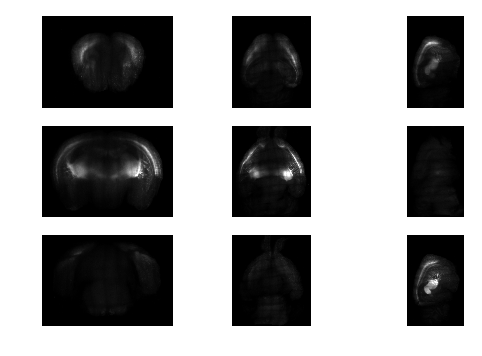

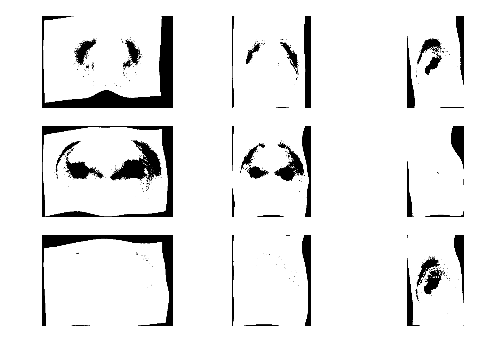

In [34]:
inImg_ds = imgResample(inImg_affine, spacing=spacing)
inMask_ds = imgResample(inMask_affine, spacing=spacing, useNearest=True)
(field, invField) = imgMetamorphosisComposite(inImg_ds, refImg_ds, inMask=inMask_ds, alphaList=[0.05, 0.02, 0.01], useMI=True, iterations=100, verbose=True)
inImg_lddmm = imgApplyField(inImg_affine, field, size=refImg.GetSize())
inMask_lddmm = imgApplyField(inMask_affine, field, size=refImg.GetSize(), useNearest=True)
imgShow(inImg_lddmm, vmax = 500)
imgShow(inMask_lddmm)

In [59]:
# Saving image
location = "img/" + 'Fear199' + "_r.nii"
imgWrite(inImg_lddmm, str(location))

# Saving annotations
location = "img/" + 'Fear199' + "_anno.nii"
imgWrite(refAnnoImg, str(location))



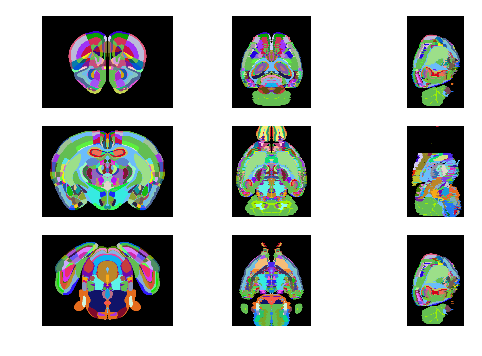

In [52]:
randValues = np.random.rand(1000,3)
randValues = np.concatenate(([[0,0,0]],randValues))
randCmap = matplotlib.colors.ListedColormap (randValues)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap)

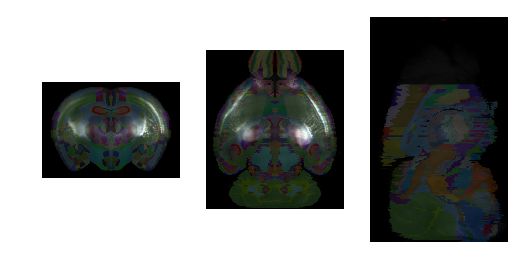

In [53]:
imgShow(inImg_lddmm, vmax=500, newFig=False, numSlices=1)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap, alpha=0.2, newFig=False, numSlices=1)

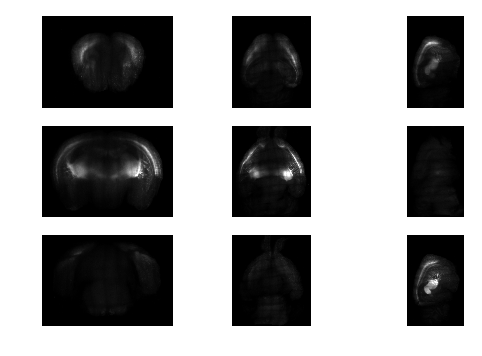

In [54]:
imgShow(inImg_lddmm, vmax = 500)

In [55]:
im = sitk.GetArrayFromImage(inImg_lddmm)
print(im.shape)

anno_im = sitk.GetArrayFromImage(refAnnoImg)
print(anno_im.shape)

(528, 320, 456)
(528, 320, 456)


In [51]:
print(im[200, 200, 200])
print(anno_im[200, 200, 200])

16
498


## Register function

In [7]:
def register(token, orientation, resolution=5):
    """ Saves fully registered brain as token + '_reg.nii'."""
    refToken = "ara_ccf2"
    refImg = imgDownload(refToken)

    refAnnoImg = imgDownload(refToken, channel="annotation")

    inImg = imgDownload(token, resolution=resolution)

    # resampling CLARITY image
    inImg = imgResample(inImg, spacing=refImg.GetSpacing())

    # reorienting CLARITY image
    inImg = imgReorient(inImg, orientation, "RSA")

    # Thresholding
    (values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0, 500))

    counts = np.bincount(values)
    maximum = np.argmax(bins)
    # print(maximum)
    # print(counts)

    lowerThreshold = maximum
    upperThreshold = sitk.GetArrayFromImage(inImg).max() + 1

    # print(lowerThreshold)
    # print(upperThreshold)

    inImg = sitk.Threshold(inImg, lowerThreshold, upperThreshold, lowerThreshold) - lowerThreshold

    # Generating CLARITY mask
    (values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=1000)
    cumValues = np.cumsum(values).astype(float)
    cumValues = (cumValues - cumValues.min()) / cumValues.ptp()

    maxIndex = np.argmax(cumValues > 0.95) - 1
    threshold = bins[maxIndex]

    inMask = sitk.BinaryThreshold(inImg, 0, threshold, 1, 0)

    # Affine Transformation
    spacing = [0.25, 0.25, 0.25]
    refImg_ds = imgResample(refImg, spacing=spacing)

    inImg_ds = imgResample(inImg, spacing=spacing)

    inMask_ds = imgResample(inMask, spacing=spacing, useNearest=True)

    affine = imgAffineComposite(inImg_ds, refImg_ds, inMask=inMask_ds, iterations=100, useMI=True, verbose=True)

    inImg_affine = imgApplyAffine(inImg, affine, size=refImg.GetSize())

    inMask_affine = imgApplyAffine(inMask, affine, size=refImg.GetSize(), useNearest=True)

    # LDDMM Registration
    inImg_ds = imgResample(inImg_affine, spacing=spacing)
    inMask_ds = imgResample(inMask_affine, spacing=spacing, useNearest=True)
    (field, invField) = imgMetamorphosisComposite(inImg_ds, refImg_ds, inMask=inMask_ds, alphaList=[0.05, 0.02, 0.01],
                                                  useMI=True, iterations=100, verbose=True)
    inImg_lddmm = imgApplyField(inImg_affine, field, size=refImg.GetSize())
    inMask_lddmm = imgApplyField(inMask_affine, field, size=refImg.GetSize(), useNearest=True)

    # Saving registered image
    location = "img/" + token + "_regis.nii"
    imgWrite(inImg_lddmm, str(location))

    # Saving annotations
    location = "img/" + token + "_anno.nii"
    imgWrite(refAnnoImg, str(location))

    return inImg_lddmm, refAnnoImg

In [8]:
register('Fear199', 'LAI', resolution=5)

IOError: Bad server response for http://openconnecto.me/ocp/ca/ara_ccf2/average/blosc/0/0,456/0,320/16,32/: 404: (2003, "Can't connect to MySQL server on 'dsp061.pha.jhu.edu' (111)")

## after Registration

(456, 320, 528)


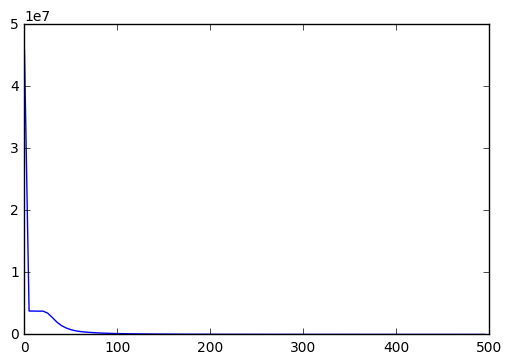

In [11]:
path = "img/" + 'Fear199_regi.nii'
real_im = nib.load(path)
real_im = real_im.get_data()

print(real_im.shape)

(values, bins) = np.histogram(real_im, bins=100, range=(0,500))
plt.plot(bins[:-1], values)

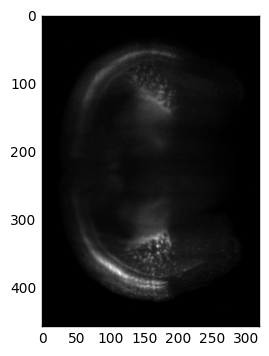

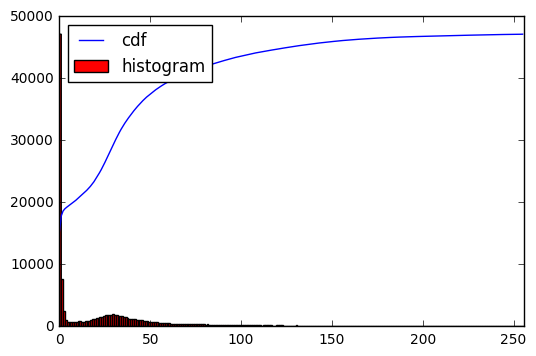

In [12]:
real_slice = real_im[:,:,250]

plt.imshow(real_slice, cmap='gray')
plt.show()

plot_hist(real_slice)

x_value = real_im.shape[0]
y_value = real_im.shape[1]
z_value = real_im.shape[2]

imgflat = real_im.reshape(-1)

In [13]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# img_grey = np.array(imgflat * 255, dtype = np.uint8)

img_grey = imgflat

cl1 = clahe.apply(img_grey)

newer_img = cl1.reshape(x_value, y_value, z_value)

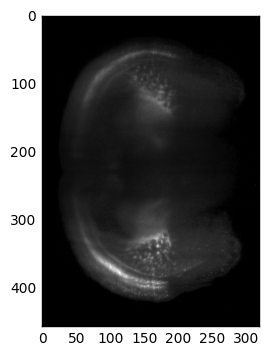

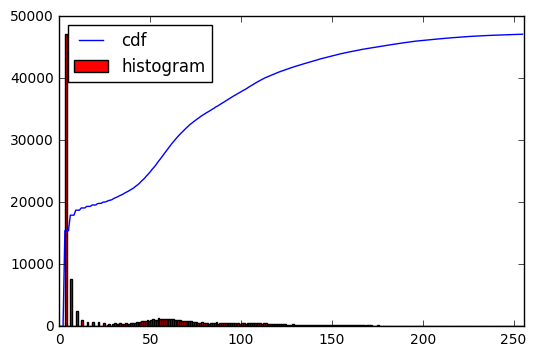

In [14]:
clahe_slice = newer_img[:,:,250]

plt.imshow(clahe_slice, cmap='gray')
plt.show()

plot_hist(clahe_slice)

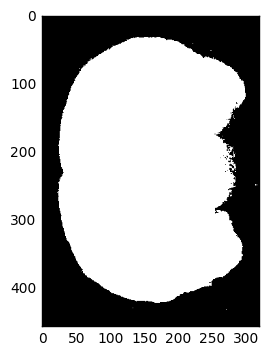

In [16]:
fear_t = thresh(newer_img, 20)

s = fear_t[:,:,250]

plt.imshow(s, cmap='gray')
plt.show()

37.136


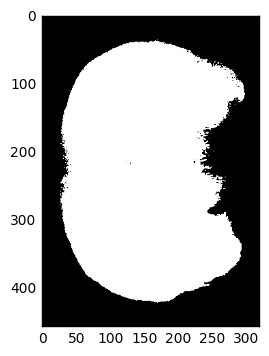

In [23]:
fear_t = thresh_cdf(newer_img, 0.40)

s = fear_t[:,:,250]

plt.imshow(s, cmap='gray')
plt.show()

32.116


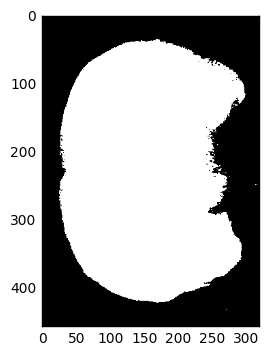

In [24]:
fear_t = thresh_cdf(newer_img, 0.35)

s = fear_t[:,:,250]

plt.imshow(s, cmap='gray')
plt.show()

19.064
num points above thresh: 30363123


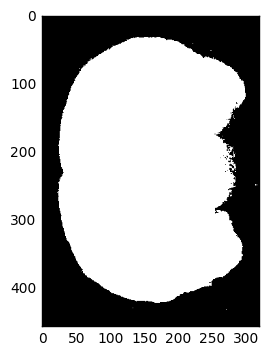

In [27]:
fear_t = thresh_cdf(newer_img, 0.25)

s = fear_t[:,:,250]

plt.imshow(s, cmap='gray')
plt.show()

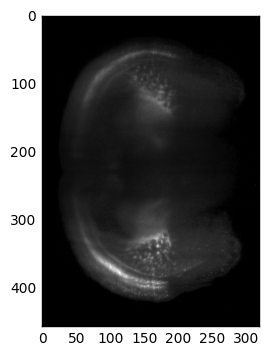

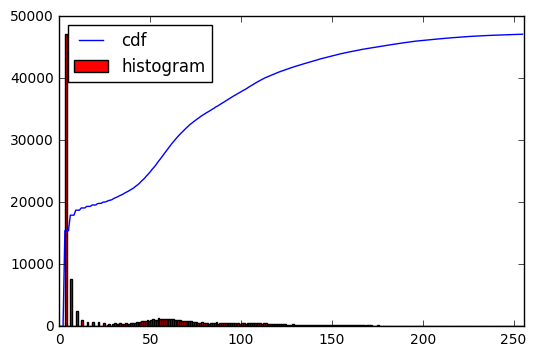

In [30]:
clahe_im = np.copy(newer_img)

clahe_slice = clahe_im[:,:,250]

plt.imshow(clahe_slice, cmap='gray')
plt.show()

plot_hist(clahe_slice)

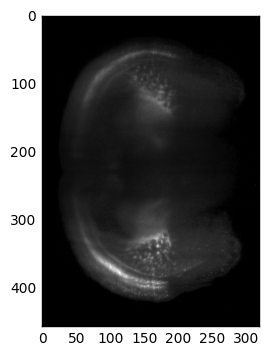

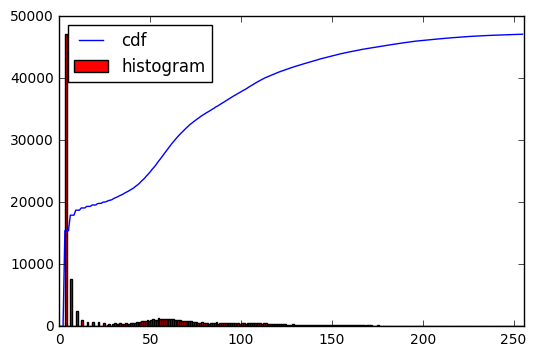

In [68]:
clahe_slice = clahe_im[:,:,250]

plt.imshow(clahe_slice, cmap='gray')
plt.show()

plot_hist(clahe_slice)

## Downsampling

In [79]:
def downsample(im, num_points = 10000, optimize = True):
    """Method to extract points data from the img file."""
    # obtaining threshold
    percentile = 0.4
    (values, bins) = np.histogram(im, bins=1000)
    cumValues = np.cumsum(values).astype(float)
    cumValues = (cumValues - cumValues.min()) / cumValues.ptp()

    maxIndex = np.argmax(cumValues>percentile)-1
    threshold = bins[maxIndex]
    print(threshold)
    
    total = im.shape[0] * im.shape[1] * im.shape[2]
#     print("Coverting to points...\ntoken=%s\ntotal=%d\nmax=%f\nthreshold=%f\nnum_points=%d" \
#           %(self._token,total,self._max,threshold,num_points))
    print("(This will take couple minutes)")
    # threshold
    im_max = np.max(im)
    filt = im > threshold
    # a is just a container to hold another value for ValueError: too many values to unpack
    #x, y, z, a = np.where(filt)
    t = np.where(filt)
    x = t[0]
    y = t[1]
    z = t[2]
    v = im[filt]
#     if optimize:
#         self.discardImg()
#     v = np.int16(255 * (np.float32(v) / np.float32(self._max)))
    l = v.shape
    print("Above threshold=%d"%(l))
    # sample

    total_points = l[0]
    print('total points: %d' % total_points)

    if not 0 <= num_points <= total_points:
        raise ValueError("Number of points given should be at most equal to total points: %d" % total_points)
    fraction = num_points / float(total_points)

    if fraction < 1.0:
        # np.random.random returns random floats in the half-open interval [0.0, 1.0)
        filt = np.random.random(size=l) < fraction
        print('v.shape:')
        print(l)
#         print('x.size before downsample: %d' % x.size)
#         print('y.size before downsample: %d' % y.size)
#         print('z.size before downsample: %d' % z.size)
        print('v.size before downsample: %d' % v.size)
        x = x[filt]
        y = y[filt]
        z = z[filt]
        v = v[filt]
#         print('x.size after downsample: %d' % x.size)
#         print('y.size after downsample: %d' % y.size)
#         print('z.size after downsample: %d' % z.size)
        print('v.size after downsample: %d' % v.size)
    points = np.vstack([x,y,z,v])
    points = np.transpose(points)
    print("Output num points: %d"%(points.shape[0]))
    print("Finished")
    return points


In [43]:
def save_points(points, output_path):
    """Saves the points to a file.  Each point consists of [x, y, z, i] where i is the grayscale intensity"""
#     pathname = 'points/Fear199.csv"
    np.savetxt(output_path, points, fmt='%d', delimiter=',')

In [47]:
def generate_pointcloud(points_path, output_path, resolution):
    """Generates the plotly from the csv file."""
    # Type in the path to your csv file here
    thedata = None
    thedata = np.genfromtxt(points_path,
        delimiter=',', dtype='int', usecols = (0,1,2), names=['a','b','c'])

    # Set tupleResolution to resolution input parameter
    tupleResolution = resolution;

    # EG: for Aut1367, the spacing is (0.01872, 0.01872, 0.005).
    xResolution = tupleResolution[0]
    yResolution = tupleResolution[1]
    zResolution = tupleResolution[2]
    # Now, to get the mm image size, we can multiply all x, y, z
    # to get the proper mm size when plotting.

    trace1 = Scatter3d(
        x = [x * xResolution for x in thedata['a']],
        y = [x * yResolution for x in thedata['b']],
        z = [x * zResolution for x in thedata['c']],
        mode='markers',
        marker=dict(
            size=1.2,
            color='cyan',                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=0.15
        )
    )

    data = [trace1]
    layout = Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        ),
        paper_bgcolor='rgb(0,0,0)',
        plot_bgcolor='rgb(0,0,0)'
    )

    fig = Figure(data=data, layout=layout)

    plotly.offline.plot(fig, filename=output_path)

#     plotly.offline.plot(fig, filename= 'output/' + self._token + "/" + self._token + "_brain_pointcloud.html")


In [80]:
im_points = downsample(clahe_im, num_points=10000)

37.136
(This will take couple minutes)
Above threshold=24373485
total points: 24373485
v.shape:
(24373485,)
v.size before downsample: 24373485
v.size after downsample: 9904
Output num points: 9904
Finished


In [81]:
save_points(im_points, 'Fear199_points.csv')

In [82]:
# obtained from doing inImg.getSpacing() for the originally downloaded clarity image
brain_res = (0.01872, 0.01872, 0.005) 
anno_res = (0.024999999999999998, 0.024999999999999998, 0.024999999999999998)
generate_pointcloud('Fear199_points.csv', 'Fear199_pointcloud.html', anno_res)

## Generating graphml

In [102]:
def csv_to_list(path):
    """Method for loading the initial csv file"""
    points = []
    with open(path, 'r') as infile:
        for line in infile:
            line = line.strip().split(',')
            entry = [int(line[0]), int(line[1]), int(line[2]), int(line[3])]
            points.append(entry)
            
#     points = np.array(points)
    return points

In [12]:
pts = np.genfromtxt('Fear199_regions.csv', delimiter=',', dtype='int')
print pts

[[ 36 162 267  48 755]
 [ 37 137 315  47 755]
 [ 38 115 303  43 251]
 ..., 
 [424 124 333  43 251]
 [424 162 339  40 836]
 [429 126 327  41 959]]


In [ ]:
def create_graph(points_path, output_filename, radius=20):
    points = np.genfromtxt(points_path, delimiter=',', dtype='int')
    
    g = nx.Graph()
    
    for point in points:
        x, y, z, intensity, region = point
        

In [103]:
def plot3d(points_path, output_filename, radius=20):
    """Method for plotting the Nodes and Edges"""
    
#     points = np.genfromtxt(points_path,
#         delimiter=',', dtype='int', usecols = (0,1,2), names=['a','b','c'])

    points = csv_to_list(points_path)

#     outpath = 'output/' + self._token + '/'
    nodename = output_filename + '_nodes.csv'
    edgename = output_filename + '_edges.csv'

    with open(nodename, 'w') as nodefile:
        with open(edgename, 'w') as edgefile:
            for ind in range(len(points)):
                temp = points[ind]
                x = temp[0]
                y = temp[1]
                z = temp[2]
                v = temp[3]
                # radius = 18
#                 radius = 25
                nodefile.write("s" + str(ind + 1) + "," + str(x) + "," + str(y) + "," + str(z) + "\n")
                for index in range(ind + 1, len(points)):
                    tmp = points[index]
                    distance = math.sqrt(math.pow(int(x) - int(tmp[0]), 2) + math.pow(int(y) - int(tmp[1]), 2) + math.pow(int(z) - int(tmp[2]), 2))
                    if distance < radius:
                            edgefile.write("s" + str(ind + 1) + "," + "s" + str(index + 1) + "\n")

In [106]:
def generate_graphml(nodefile_path, edgefile_path, output_path):
    """
    Method for extracting the data to a graphml file, based on the node and edge files.  
    Example outfile_path: Fear199.graphml
    """
    nodes = []
    with open(nodefile_path, 'r') as infile:
        for line in infile:
            line = line.strip().split(',')
            entry = [line[0], line[1], line[2], line[3]]
            nodes.append(entry)
    
    edges = []
    with open(edgefile_path, 'r') as infile:
        for line in infile:
            line = line.strip().split(',')
            entry = [line[0], line[1]]
            edges.append(entry)
            
    # Start writing to the output graphml file
    with open(output_path, 'w') as outfile:
        outfile.write("<?xml version=\"1.0\" encoding=\"UTF-8\"?>\n")
        outfile.write("<graphml xmlns=\"http://graphml.graphdrawing.org/xmlns\"\n")
        outfile.write("         xmlns:xsi=\"http://www.w3.org/2001/XMLSchema-instance\"\n")
        outfile.write("         xsi:schemaLocation=\"http://graphml.graphdrawing.org/xmlns\n")
        outfile.write("         http://graphml.graphdrawing.org/xmlns/1.0/graphml.xsd\">\n")

        outfile.write("  <key id=\"d0\" for=\"node\" attr.name=\"attr\" attr.type=\"string\"/>\n")
        outfile.write("  <key id=\"e_weight\" for=\"edge\" attr.name=\"weight\" attr.type=\"double\"/>\n")
        outfile.write("  <graph id=\"G\" edgedefault=\"undirected\">\n")

        for line in nodes:
#              if len(line) == 0:
#                  continue
             outfile.write("    <node id=\"" + line[0] + "\">\n")
             outfile.write("      <data key=\"d0\">[" + line[1] + ", " + line[2] + ", " + line[3] +"]</data>\n")
             outfile.write("    </node>\n")

        for line in edges:
#              if len(line) == 0:
#                  continue
             outfile.write("    <edge source=\"" + line[0] + "\" target=\"" + line[1] + "\">\n")
             outfile.write("      <data key=\"e_weight\">1</data>\n")
             outfile.write("    </edge>\n")

        outfile.write("  </graph>\n</graphml>")


In [96]:
plot3d('Fear199_points.csv', 'Fear199', radius=20)

In [108]:
start = time.time()
generate_graphml('Fear199_nodes.csv', 'Fear199_edges.csv', 'Fear199.graphml')
run_time = time.time() - start
print('run time: %f' % run_time)

run time: 0.114961


## Getting the regions

In [ ]:
def csv_to_list2(path):
    """Method for loading the initial csv file"""
    points = []
    with open(path, 'r') as infile:
        for line in infile:
            line = line.strip().split(',')
            entry = [line[0], line[1], int(line[2]), int(line[3])]
            points.append(entry)
            
#     points = np.array(points)
    return points

In [115]:
def get_regions(points_path, anno_path, output_path):
    """
    points_path is a .csv
    anno_path is a .nii
    output_path is a .csv (e.g. Fear199_regions.csv)
    """
    atlas = nib.load(anno_path)  # <- atlas .nii image
    atlas_data = atlas.get_data()

    points = np.genfromtxt(points_path, delimiter=',')

    locations = points[:, 0:3]
    
    # getting the region numbers
    regions = [atlas_data[l[0], l[1], l[2]] for l in locations]

    outfile = open(output_path, 'w')
    infile = open(points_path, 'r')
    for i, line in enumerate(infile):
        line = line.strip().split(',')
        outfile.write(",".join(line) + "," + str(regions[i]) + "\n")    # adding a 5th column to the original csv indicating its region (integer)
    infile.close()
    outfile.close()

    print len(regions)
#     print regions[0:10]
    uniq = list(set(regions))
    numRegions = len(uniq)
    print ('num unique regions: %d' % len(uniq))
    print uniq
    
    p = np.genfromtxt(output_path, delimiter=',')
    return p

#     # newToken = Token + '.region'
#     atlas = atlasregiongraph(Token)
    
#     atlas.generate_atlas_region_graph(tupleResolution, None, numRegions)

In [116]:
rp = get_regions('Fear199_points.csv', 'img/Fear199_anno.nii', 'Fear199_regions.csv')
print(rp)

9904
num unique regions: 578
[0, 2, 7, 8, 9, 10, 12, 15, 17, 19, 20, 23, 26, 27, 28, 33, 36, 41, 42, 45, 50, 52, 53, 55, 56, 59, 60, 61, 64, 68, 69, 74, 77, 82, 83, 84, 87, 91, 92, 96, 99, 101, 105, 106, 113, 114, 115, 118, 120, 121, 122, 123, 128, 130, 131, 132, 133, 135, 136, 137, 139, 10723, 146, 148, 149, 151, 155, 156, 159, 160, 162, 163, 167, 169, 170, 171, 175, 178, 180, 181, 183, 186, 187, 188, 189, 191, 192, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 206, 209, 211, 212, 214, 215, 216, 217, 218, 220, 222, 224, 225, 226, 228, 231, 232, 233, 234, 236, 238, 240, 241, 243, 244, 246, 248, 250, 251, 252, 255, 256, 257, 258, 260, 262, 266, 267, 268, 269, 271, 274, 276, 278, 279, 281, 284, 288, 289, 291, 292, 296, 298, 303, 304, 305, 307, 308, 310, 311, 312, 313, 314, 320, 321, 325, 327, 328, 330, 333, 334, 335, 338, 340, 342, 344, 354, 358, 360, 363, 364, 366, 368, 374, 377, 381, 391, 399, 401, 407, 408, 411, 412, 414, 415, 416, 418, 421, 422, 424, 427, 429, 430, 431, 10672, 43

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



In [10]:
pts = np.genfromtxt('Fear199_regions.csv', delimiter=',')
print(pts)

[[  36.  162.  267.   48.  755.]
 [  37.  137.  315.   47.  755.]
 [  38.  115.  303.   43.  251.]
 ..., 
 [ 424.  124.  333.   43.  251.]
 [ 424.  162.  339.   40.  836.]
 [ 429.  126.  327.   41.  959.]]


In [111]:
p = np.genfromtxt('Fear199_points.csv', delimiter=',')
print(p)

[[  36.  162.  267.   48.]
 [  37.  137.  315.   47.]
 [  38.  115.  303.   43.]
 ..., 
 [ 424.  124.  333.   43.]
 [ 424.  162.  339.   40.]
 [ 429.  126.  327.   41.]]


# Running on Aut1379

In [9]:
register('Aut1367', 'RPS')

IOError: Bad server response for http://openconnecto.me/ocp/ca/ara_ccf2/average/blosc/0/0,456/0,320/16,32/: 404: (2003, "Can't connect to MySQL server on 'dsp061.pha.jhu.edu' (111)")

## Downsampling testing

In [55]:
# obtaining threshold
im_t = np.copy(clahe_im)
percentile = 0.4

(values, bins) = np.histogram(im_t, bins=1000)
cumValues = np.cumsum(values).astype(float)
cumValues = (cumValues - cumValues.min()) / cumValues.ptp()

maxIndex = np.argmax(cumValues>percentile)-1
threshold = bins[maxIndex]
print(threshold)

37.136


In [78]:
im = np.copy(clahe_im)
               
num_points = 7000

"""Method to extract points data from the img file."""
# threshold = .6
total = im.shape[0] * im.shape[1] * im.shape[2]
#     print("Coverting to points...\ntoken=%s\ntotal=%d\nmax=%f\nthreshold=%f\nnum_points=%d" \
#           %(self._token,total,self._max,threshold,num_points))
print("(This will take couple minutes)")
# threshold
im_max = np.max(im)
# filt = im > threshold * im_max
filt = im > threshold
# a is just a container to hold another value for ValueError: too many values to unpack
#x, y, z, a = np.where(filt)
t = np.where(filt)
x = t[0]
y = t[1]
z = t[2]
v = im[filt]
#     if optimize:
#         self.discardImg()
#     v = np.int16(255 * (np.float32(v) / np.float32(self._max)))
l = v.shape
print("Above threshold=%d"%(l))
# sample

total_points = l[0]
print('total points: %d' % total_points)

if not 0 <= num_points <= total_points:
    raise ValueError("Number of points given should be at most equal to total points: %d" % total_points)
fraction = num_points / float(total_points)

if fraction < 1.0:
    # np.random.random returns random floats in the half-open interval [0.0, 1.0)
    filt = np.random.random(size=l) < fraction
    print('v.shape:')
    print(l)
#     print('x.size before downsample: %d' % x.size)
#     print('y.size before downsample: %d' % y.size)
#     print('z.size before downsample: %d' % z.size)
    print('v.size before downsample: %d' % v.size)
    x = x[filt]
    y = y[filt]
    z = z[filt]
    v = v[filt]
#     print('x.size after downsample: %d' % x.size)
#     print('y.size after downsample: %d' % y.size)
#     print('z.size after downsample: %d' % z.size)
    print('v.size after downsample: %d' % v.size)
points = np.vstack([x,y,z,v])
points = np.transpose(points)
print("Output num points: %d"%(points.shape[0]))
print("Finished")

(This will take couple minutes)
Above threshold=24373485
total points: 24373485
v.shape:
(24373485,)
v.size before downsample: 24373485
v.size after downsample: 7005
Output num points: 7005
Finished


In [59]:
save_points(points, 'Fear199_points_test.csv')

In [60]:
res = (0.01872, 0.01872, 0.005) # obtained from doing inImg.getSpacing() for the originally downloaded clarity image
generate_pointcloud('Fear199_points_test.csv', 'Fear199_pointcloud_test.html', res)

In [53]:
print(np.max(clahe_im))

1007
